# **<리모델링 여부가 주택 가격에 영향을 미칠까?>**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 데이터 전처리

## 1-1. 데이터 임포트

In [2]:
df = pd.read_csv("1st_train_mdf.csv")

## 1-2. 데이터 전처리: 누락값의 처리

- 누락값은 아니지만 id는 sale price와 상관관계를 파악하는 데 필요없다고 판단, 제거하였음

In [3]:
df = df.drop(['Id'], axis = 1)

- 누락값 확인

In [4]:
null_data= df.isnull().sum()
df.isnull().sum()[df.isnull().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

- 데이터의 80% 이상(1000개)이 결측치인 데이터들은 삭제
- 해당 데이터의 누락 원인: 해당 시설 None

In [5]:
null_data[null_data.values > 1000].index

Index(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], dtype='object')

In [6]:
df.drop(["Alley", "PoolQC", "Fence", "MiscFeature"], axis = 1,inplace = True)

- 259(17.7%)인 데이터 LotFrontage는 중위값으로 채워줌
- 누락 원인: 알 수 없음

In [7]:
df.LotFrontage.fillna(df.LotFrontage.median(), inplace=True)

- 수치형 데이터는 0, 범주형 데이터는 'None'으로 처리
- 누락 원인: 벽돌외장 면적 0, None

In [8]:
df.loc[df.MasVnrArea.isnull(),['MasVnrArea','MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [9]:
df.MasVnrArea.fillna(0, inplace=True)  
df.MasVnrType.fillna('None', inplace=True) 

- 누락원인: 해당 시설 None

In [10]:
df.GarageType.fillna('None', inplace=True)
df.GarageYrBlt.fillna('None', inplace=True)
df.GarageFinish.fillna('None', inplace=True)
df.GarageQual.fillna('None', inplace=True)
df.GarageCond.fillna('None', inplace=True)

In [11]:
df.BsmtQual.fillna('None', inplace=True)
df.BsmtCond.fillna('None', inplace=True)
df.BsmtExposure.fillna('None', inplace=True)
df.BsmtFinType1.fillna('None', inplace=True)
df.BsmtFinType2.fillna('None', inplace=True)
df.FireplaceQu.fillna('None', inplace=True)

- 제일 빈도가 큰값(Top)인 SBrkr으로 처리
- 누락원인: 알 수 없음

In [12]:
df.Electrical.fillna("SBrkr", inplace=True)

- 결측값이 더 이상 없는 것 확인

In [13]:
df.isnull().sum()[df.isnull().sum()>0]

Series([], dtype: int64)

## 1-3. Visualization

**중요변수 확인**

<AxesSubplot:>

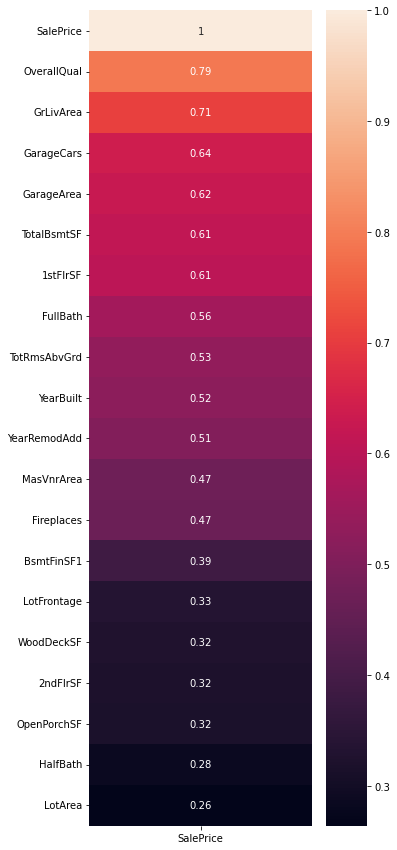

In [14]:
corr_matrix = df.corr()
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix[['SalePrice']].sort_values(by=['SalePrice'],
                                ascending=False).head(20),annot=True)

- YearBuilt, YearRemod가 0.59, 0.57의 상관관계로 해당 데이터에서 높은 상관관계를 보여주고 있음

In [15]:
bins = [0, 1959, 1979, 1999, 2019]
group_names = ['1950s', '1960s~1970s', '1980s~1990s', '2000s~2010s']

In [16]:
df['YrSold'].describe()

count    1460.000000
mean     2007.815753
std         1.328095
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64

- 리모델링 여부 관계를 확인하면서 '언제 팔렸는지'의 변수또한 중요하다고 생각했는데
- 년도들이 그리 차이나지 않아서(1년 4개월정도) 고려대상에서 제외하였다.

In [17]:
year_cats = pd.cut(df['YearRemodAdd'], bins, labels=group_names)
df[['YearBuilt', 'YearRemodAdd']]

,YearBuilt,YearRemodAdd
0,2003,2003
1,1976,1976
2,2001,2002
3,1915,1970
4,2000,2000
...,...,...
1455,1999,2000
1456,1978,1988
1457,1941,2006
1458,1950,1996


In [18]:
df['IsRemodel'] = df[['YearBuilt', 'YearRemodAdd']].apply(lambda x: "No-Remod" if x[0] == x[1] 
                                                          else "Yes-Remod", axis = 1)

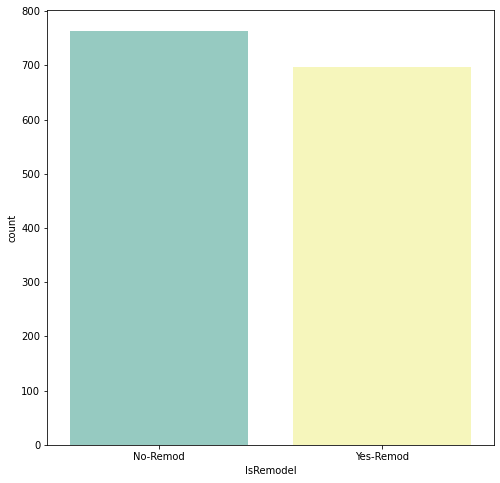

In [24]:
fig, axes = plt.subplots(figsize=(8,8))
sns.countplot(x = df['IsRemodel'], palette="Set3")
plt.show()

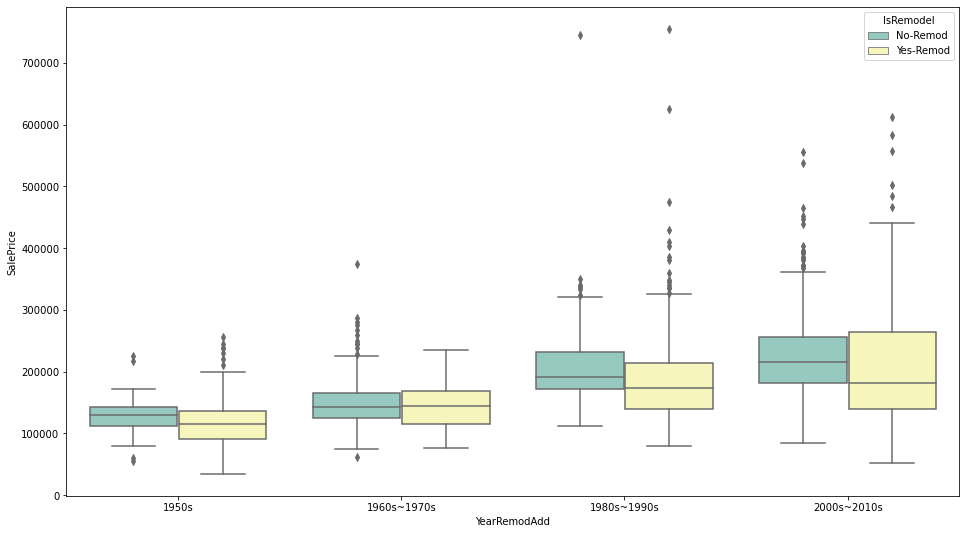

In [22]:
plt.figure(figsize=(16,9))
plt.rc('axes', axisbelow = True)
sns.boxplot(data=df, y="SalePrice", x=year_cats, palette = "Set3", hue = 'IsRemodel')
plt.show()

## 1-4. 원-핫 인코딩

In [25]:
df = pd.get_dummies(df)

## 1-5. 로그변환 

- SalePrice 데이터를 보면 왼쪽으로 치우쳐 있고, 정규분포에서 많이 벗어난 모습을 볼 수 있음
- 양의 왜도 또한 나타나 있음

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


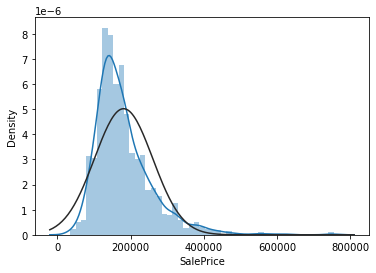

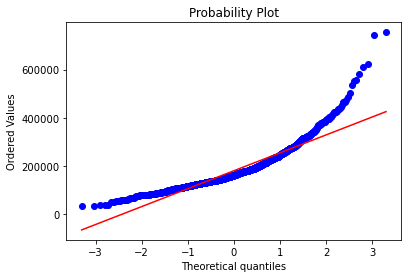

In [26]:
import scipy.stats as st
sns.distplot(df['SalePrice'], fit=st.norm)
fig = plt.figure()
res = st.probplot(df['SalePrice'], plot=plt)

- 로그 변환 후, 정규분포와 빨간 사선에 모두 부합한 모습

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


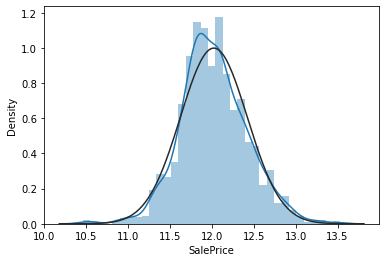

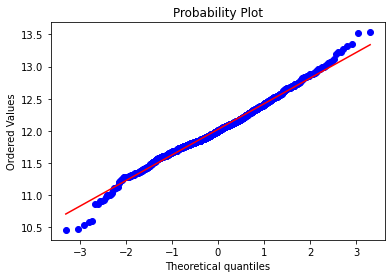

In [27]:
df['SalePrice'] = np.log(df['SalePrice'])
sns.distplot(df['SalePrice'], fit=st.norm)
fig = plt.figure()
res = st.probplot(df['SalePrice'], plot=plt)

## 1-6. 데이터세트를 훈련용, 테스트용으로 분할

In [28]:
# trainset, testset 분리
from sklearn.model_selection import train_test_split
X = df.drop('SalePrice', axis = 1)
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

# 2. 예측 모델 구현

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # MSE
from sklearn.model_selection import cross_val_score

## 2-1. 선형 회귀

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
lin_rmse = np.sqrt((-lin_scores).mean())
lin_rmse

13712.537839819337

## 2-2. 규제모델 적용

In [31]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

### Ridge(릿지)

In [32]:
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
ridge_scores = cross_val_score(ridge_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5 )
ridge_reg_rmse = np.sqrt((-ridge_scores).mean())
ridge_reg_rmse

0.15741288245359034

### Lasso(라쏘)

In [33]:
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
lasso_scores = cross_val_score(lasso_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv=10, n_jobs=-1)
lasso_rmse = np.sqrt(-lasso_scores).mean()
lasso_rmse

0.1965057828911776

### ElasticNet(엘라스틱넷)

In [34]:
elastic_reg = ElasticNet()
elastic_reg.fit(X_train, y_train)
elastic_scores = cross_val_score(elastic_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv=10, n_jobs=-1)
elastic_rmse = np.sqrt(-elastic_scores).mean()
elastic_rmse

0.19069598691213752

## 2-3 선형 회귀계수 시각화

In [35]:
def get_top_bottom_coef(model):
    # coef_ > Series 생성 
    coef = pd.Series(model.coef_, index=X.columns)    
    # 상위 10개 , 하위 10개 회귀계수 Series 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)

    return coef_high, coef_low

def visualize_coefficient(models):

    # subplot 생성
    fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=len(models), constrained_layout=True)
    # 모델별 회귀계수 시각화
    for i_num, model in enumerate(models):
        # get_top_bottom_coef 함수 호출 > concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high , coef_low], axis=0)
        
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents')         # title
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num]) # barplot

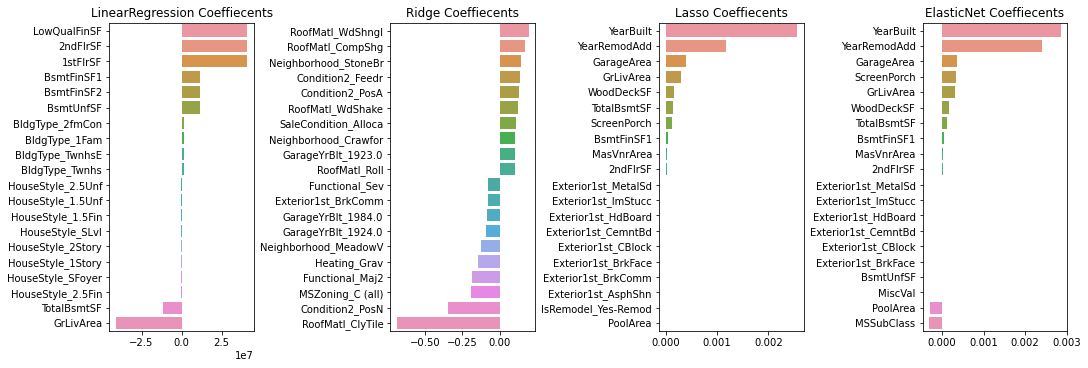

In [36]:
models = [lin_reg, ridge_reg, lasso_reg, elastic_reg]
visualize_coefficient(models)

- Lasso, ElasticNet에서 YearBuilt, YearRemodAdd가 주택가격에 영향을 미치는 변수 top2로 나타남

## 2-4. RandomForest(랜덤포레스트)

In [37]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
rf_scores = cross_val_score(rf_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
rf_rmse = np.sqrt((-rf_scores).mean())
rf_rmse

0.14632901797290163

## 2-5. DecisionTree(의사결정트리)

In [38]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)
tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
tree_rmse = np.sqrt((-tree_scores).mean())
tree_rmse

0.2034797713697617

## 2-6. XGB

In [39]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
xgb_scores = cross_val_score(xgb_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
xgb_rmse = np.sqrt((-xgb_scores).mean())
xgb_rmse

0.1403799882028546

# 3. 파라미터 튜닝

## 3-1. 그리드탐색(GridSearch)

In [41]:
from sklearn.model_selection import GridSearchCV

### Ridge, Lasso, ElasticNet

In [42]:
params = {'alpha':[0.0001,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,12,15,20,25,30]}
models = [ridge_reg,lasso_reg, elastic_reg]

for model in models:
    grid = GridSearchCV(model, param_grid = params, cv=10, scoring = 'neg_mean_squared_error',n_jobs=-1)
    grid.fit(X,y)
    rmse = np.sqrt(-1*grid.best_score_)
    print('{0} 10 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,rmse, grid.best_params_))

Ridge 10 CV 시 최적 평균 RMSE 값: 0.14138500155873734, 최적 alpha:{'alpha': 15}
Lasso 10 CV 시 최적 평균 RMSE 값: 0.14258860975561335, 최적 alpha:{'alpha': 0.001}
ElasticNet 10 CV 시 최적 평균 RMSE 값: 0.14026914972336943, 최적 alpha:{'alpha': 0.001}


### RandomForest

In [43]:
param_grid = {'n_estimators' : [1,10, 100],
              'max_depth' : [6, 8, 10, 12],
              'min_samples_leaf' : [8, 12, 18],
              'min_samples_split' : [8, 16, 20]
}
rf_grid_search = GridSearchCV(rf_reg, param_grid, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

for mean_score, params in zip(rf_grid_search.cv_results_['mean_test_score'], rf_grid_search.cv_results_['params']):
    print(np.sqrt((-rf_scores).mean()), params)

0.14632901797290163 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 1}
0.14632901797290163 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 10}
0.14632901797290163 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
0.14632901797290163 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 1}
0.14632901797290163 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 10}
0.14632901797290163 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}
0.14632901797290163 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 1}
0.14632901797290163 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 10}
0.14632901797290163 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}
0.14632901797290163 {'max_depth': 6, 'min_samples_leaf': 1

In [44]:
rf_grid_search.best_params_

{'max_depth': 12,
 'min_samples_leaf': 8,
 'min_samples_split': 16,
 'n_estimators': 100}

### best
0.14632901797290163 {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100}

**0.20->0.146**

### DecisionTree

In [53]:
tree_param_grid = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [54]:
tree_grid_search = GridSearchCV(tree_reg, tree_param_grid, scoring="neg_mean_squared_error",cv=10, n_jobs=-1)
tree_grid_search.fit(X_train, y_train)

for mean_score, params in zip(tree_grid_search.cv_results_['mean_test_score'], tree_grid_search.cv_results_['params']):
    print(np.sqrt((-tree_scores).mean()), params)

In [55]:
tree_grid_search.best_params_

### XGB

In [56]:
xgb_param_grid = {'learning_rate': [1,0.1,0.01,0.001],
              'n_estimators': [50, 100, 200, 500, 1000],
              'max_depth' : [1,5,10,50]}

In [ ]:
xgb_grid_search = GridSearchCV(xgb_reg, xgb_param_grid, scoring="neg_mean_squared_error",cv=10, n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

for mean_score, params in zip(xgb_grid_search.cv_results_['mean_test_score'], xgb_grid_search.cv_results_['params']):
    print(np.sqrt((-xgb_scores).mean()), params)

In [ ]:
xgb_grid_search.best_params_

# 4. 검증

In [ ]:
import statsmodels.api as sm

In [ ]:
X_train=sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()